## Meep (Python) installation guide - Colab ver.

In [1]:
# install conda
!pip install -q condacolab
import condacolab
condacolab.install()

!which conda

# install meep (python)
!conda install -c conda-forge pymeep

## Parallel Meep (MPI version)
!conda create -n pmp -c conda-forge pymeep=*=mpi_mpich_*
!conda activate pmp

# Install Additional Packages 
!pip install nlopt

print("Meep installation complete. You can now run Meep in Python.")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...
/usr/local/bin/conda
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \

#### Meep example code for testing
Soruce : https://github.com/NanoComp/meep/blob/master/python/examples/adjoint_optimization/01-Introduction.ipynb

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

def J(alpha):
    return npa.abs(alpha) ** 2

mp.verbosity(0)
seed = 240
np.random.seed(seed)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-1, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

design_region_resolution = 10
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE0]

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

x0 = np.random.rand(Nx * Ny)
try :
    opt.update_design([x0])

except Exception as e:
    print(e)

/usr/local/lib/python3.10/site-packages/meep/visualization.py:519: UserWarning: The frequency parameter of plot2D has been deprecated. Use the frequency key of the eps_parameters dictionary instead.
  warnings.warn(


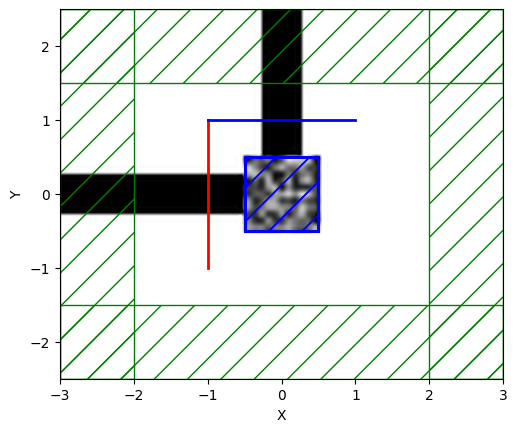

In [2]:
opt.plot2D(True, frequency=1 / 1.55)
plt.show()

In [3]:
f0, dJ_du = opt()

Starting forward run...
Starting adjoint run...
Calculating gradient...


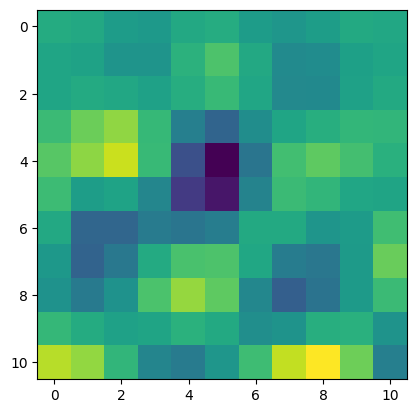

In [4]:
plt.figure()
plt.imshow(np.rot90(dJ_du.reshape(Nx, Ny)))